<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'


In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                             
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 5; # computational length of sample    
Lx = 30e-3; # computational width of sample          
Chirp = -0.0*6*230000.0; # input linear chirp parameter         
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.5e-3 # beam width of gaussian beam parameter

In [0]:
################## Computational Parameters #############
nstepx = 1*1024; # number of transverse grid points
nstepz = 20; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step       

In [49]:
print(f"Delta X: {deltax}")

Delta X: 2.9296875e-05


In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = np.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(np.arange(0, nstepx, 1))*deltax; # x array               

X, Y = np.meshgrid(x,x); # x and y grid

In [0]:
##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = np.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = np.meshgrid(kx, kx);

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = np.sqrt(Ip)*np.exp(-(X**2+Y**2)/(w0**2));

InputPower = np.abs(InputField)**2

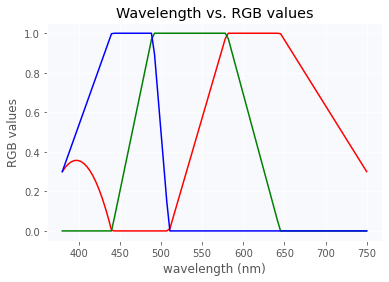

In [22]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return np.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100)
rgbs = np.asarray([wavelength_to_rgb(wl) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

In [0]:
cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment

In [0]:
# we define a function to plot 
def plot(Power, figsize=(15, 15), width=15, unit="mm", _cmap=cmap):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=_cmap, extent=[-width,width,-width,width], vmin=0)

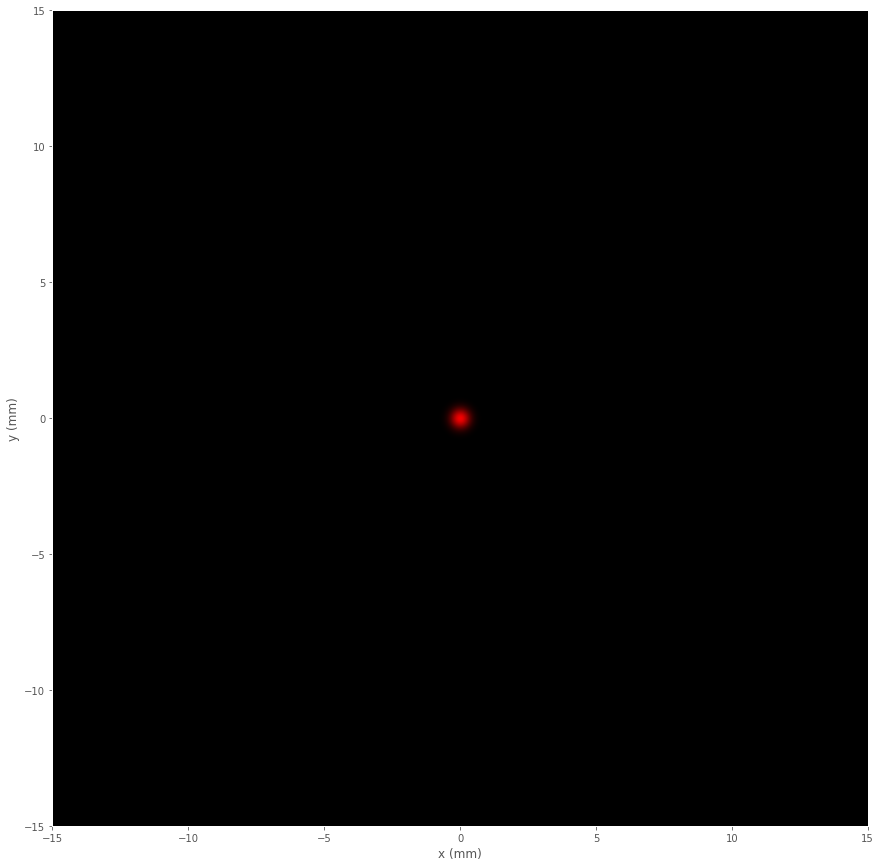

In [25]:
plot(InputPower)

In [0]:
fft2, ifft2= np.fft.fft2, np.fft.ifft2

In [27]:
######                    PROPAGATION LOOP                  ########

def propagate(InputField, k, nstepz=nstepz, deltaz=deltaz):
  # keeps a record of field module at every step
  FieldModuleMemory = np.zeros(shape=(nstepx, nstepx, nstepz+1))
  FieldModuleMemory[..., 0] = np.abs(InputField)
  PropagatingField = InputField.copy()
  ArgumentOfPropagator  = ((k*n0)**(-1)*(KX**2+KY**2))*(deltaz/2);             
  Propagator = np.exp(1j*ArgumentOfPropagator)
  tstart = time.time()
  for hh in range(nstepz):
      
      PropagatingFieldTransform = fft2(PropagatingField)*Propagator
      PropagatingField = ifft2(PropagatingFieldTransform)
      FieldModuleMemory[..., 1+hh] = np.abs(PropagatingField)

  print(f"Lasted {time.time()-tstart} seconds")
  return PropagatingField, FieldModuleMemory

OutputField, FieldModuleMemory = propagate(InputField, k0)
OutputPower = np.abs(OutputField)**2

OutputTotalPower = np.sum(OutputPower) # total power on output plane
InputTotalPower = np.sum(InputPower) # total power on input plane
gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)

if abs(gap) > 1e-14:
  print(gap)

Lasted 2.537992477416992 seconds


In [0]:
# we evaluate an estimation of error due to low z resolution
estimate_error = False
if estimate_error:
  high_res_field = np.abs(propagate(InputField, k0, nstepz=200, deltaz=Lz/200))
  low_res_field = np.abs(propagate(InputField, k0, nstepz=20, deltaz=Lz/20))
  error = np.abs(low_res_field-high_res_field)
  max_error = np.max(error)
  print(f"Max_error: {max_error}")

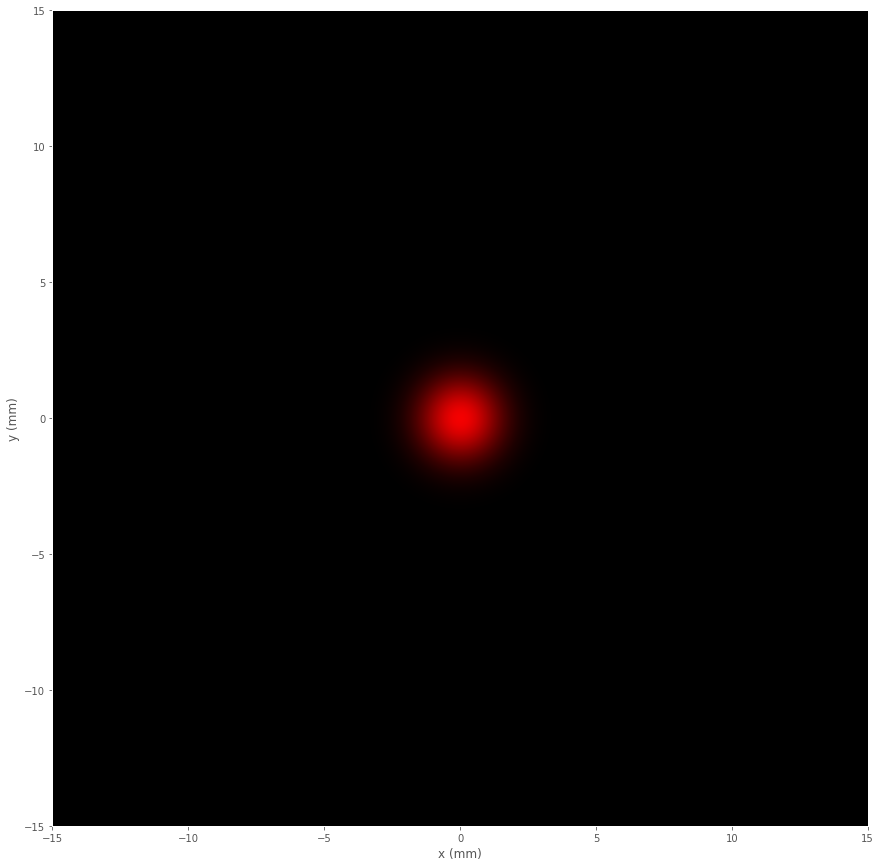

In [29]:
plt.close()
plot(OutputPower)

Lasted 2.3345885276794434 seconds
Lasted 2.5694451332092285 seconds


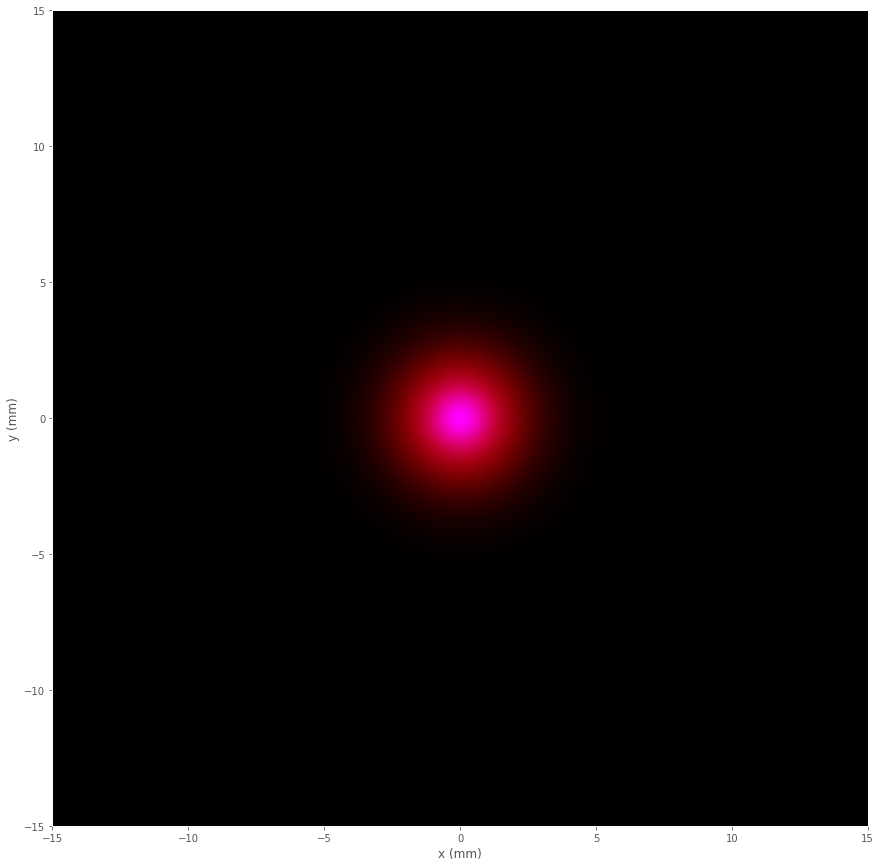

In [30]:
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/wavelength
  OutputField = propagate(InputField, k)[0]
  P = abs(OutputField)**2
  rgb = np.stack((P,)*3, axis=-1)/np.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9)

InputField1 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6)
plot(RedPower + BluePower) #purple point with red cirle 
# red + blue = purple

In [0]:
# we evaluate beam widths as the 2nd moment of a gaussian function

# extends grids X and Y to a third axis
# in order to make possible multiplying by FieldModuleMemory
_X = np.stack((X,)*(nstepz+1), axis=-1)
_Y = np.stack((Y,)*(nstepz+1), axis=-1)

norms = np.sum(FieldModuleMemory, axis=(0, 1))
widths = np.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)

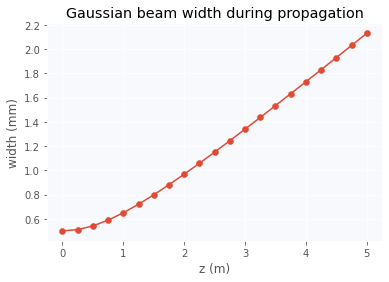

In [32]:
plt.scatter(z, 1000*widths)
z0 = k0*w0**2/2 # Rayleigh's width
plt.plot(z, 1000*w0*np.sqrt(1+z**2/z0**2))
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("Gaussian beam width during propagation")
plt.show()

In [0]:
PlaneInputField = 0*X
dist = 0.5e-3
width = 1e-3
a = X < 0.001
b = X > -0.001

PlaneInputField[np.abs(X-dist/2) < width] = 1
PlaneInputField[np.abs(X+dist/2) < width] = 1

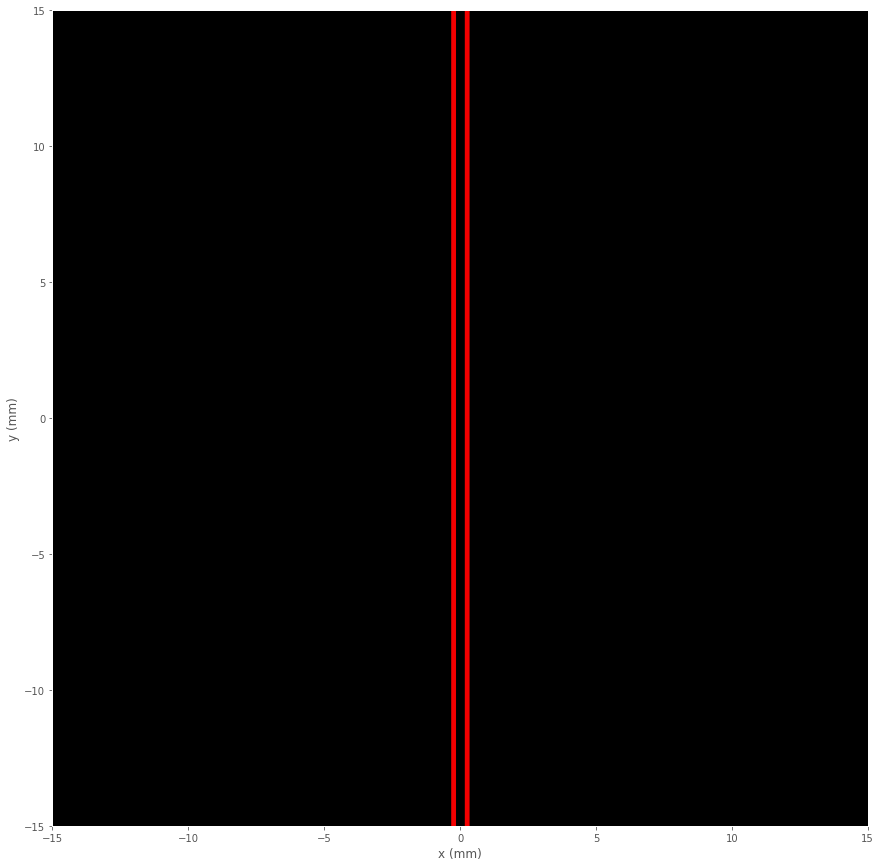

In [55]:
plot(PlaneInputField)

Lasted 2.456021547317505 seconds
Lasted 2.481997013092041 seconds


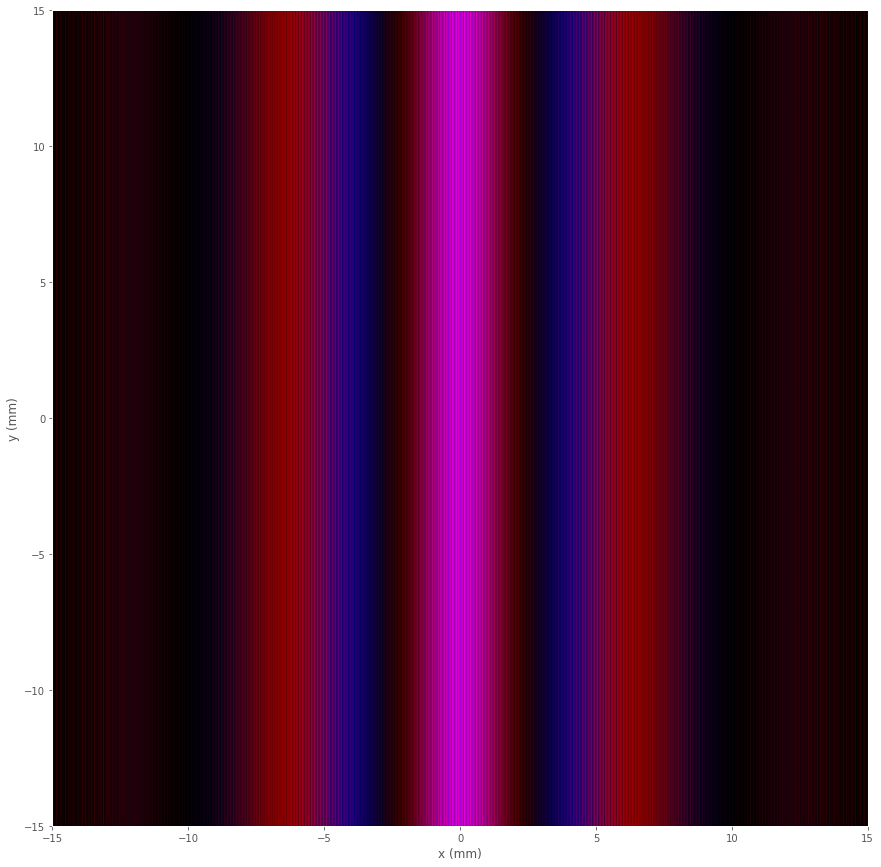

In [61]:
Red = propagate_and_get_rgb(PlaneInputField, 0.65e-6)
Blue = propagate_and_get_rgb(PlaneInputField, 0.44e-6)

plot(Red+Blue)